# Imprt Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

Preprocessing Function

In [15]:
# Load and preprocess data
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

def logistic_regression_preprocessing(df):
    df = df.drop('customerID', axis=1)
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
    df['TenureToMonthlyRatio'] = df['TotalCharges'] / (df['MonthlyCharges'] + 1e-6)
    df['HasMultipleServices'] = (df[['OnlineSecurity', 'OnlineBackup',
                                     'DeviceProtection', 'TechSupport']] == 'Yes').sum(axis=1) > 1

    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in service_cols:
        df[col] = df[col].replace({'No internet service': 'No'})

    df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    return df

df = logistic_regression_preprocessing(df)

Preprocess data

In [16]:


# Split data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify=y, random_state=42)

# Preprocessing setup
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TenureToMonthlyRatio']
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService',
                        'MultipleLines', 'InternetService', 'Contract',
                        'PaperlessBilling', 'PaymentMethod', 'HasMultipleServices']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='if_binary'), categorical_features)
])

Apply preprocessing and run the model

In [17]:
# Create optimized pipeline
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'smote__sampling_strategy': [0.5, 0.7, 0.9]
}

# Grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                          scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'classifier__C': 0.001, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'smote__sampling_strategy': 0.5}
Test Accuracy: 0.7864

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.63      0.47      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409



Model evalution

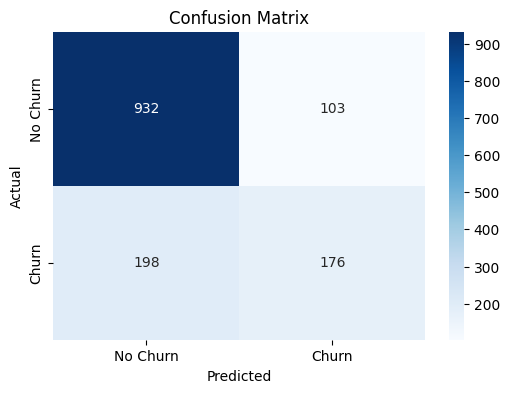

Top 10 Feature Importances


<ipython-input-18-d04b5e08a0f0>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance[:10], palette='viridis')


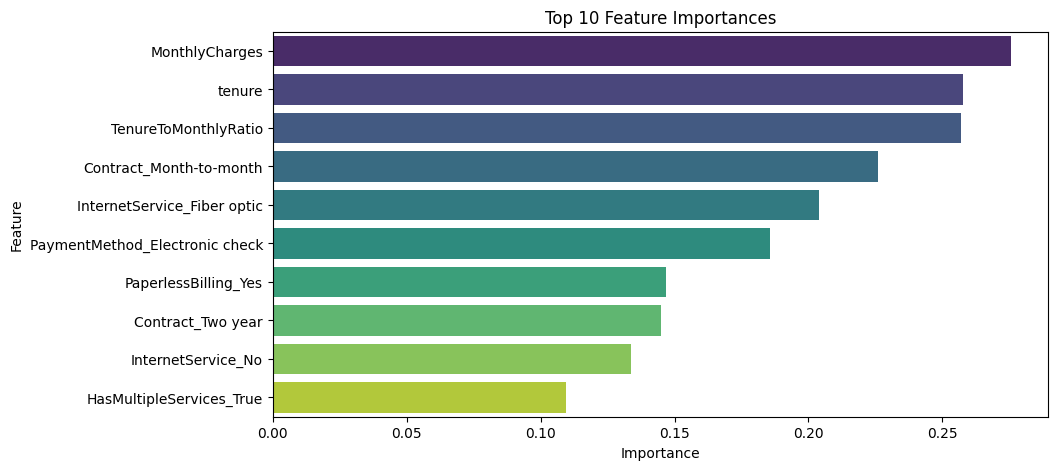

ROC Curve


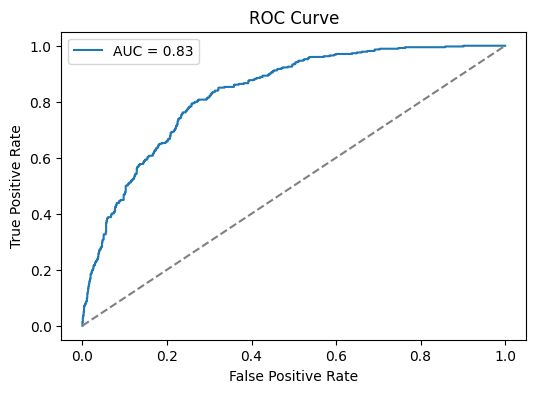

Hyperparameter Tuning Grid Search


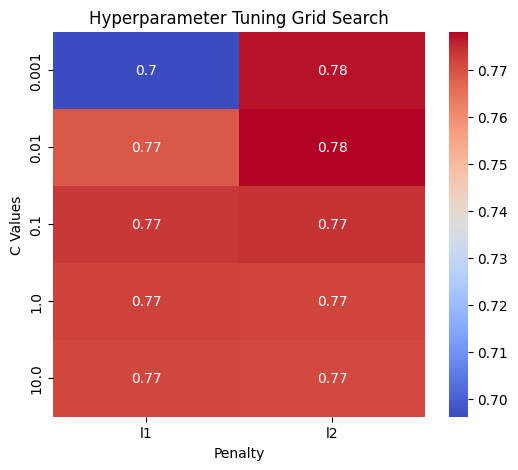

In [18]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Top 10 Feature Importances")
# Feature Importance
coefficients = best_model.named_steps['classifier'].coef_[0]
feature_names = (numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)))
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance[:10], palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

print("ROC Curve")
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print("Hyperparameter Tuning Grid Search")
# Grid Search Heatmap
heatmap_data = pd.DataFrame(grid_search.cv_results_)
heatmap_pivot = heatmap_data.pivot_table(index='param_classifier__C', columns='param_classifier__penalty', values='mean_test_score', aggfunc='mean')
plt.figure(figsize=(6,5))
sns.heatmap(heatmap_pivot, annot=True, cmap='coolwarm')
plt.title('Hyperparameter Tuning Grid Search')
plt.ylabel('C Values')
plt.xlabel('Penalty')
plt.show()

Save the model

In [19]:
joblib.dump(best_model, "logistic_model.pkl")
print("Model saved successfully as logistic_model.pkl")

Model saved successfully as logistic_model.pkl


In [23]:
import pandas as pd
import numpy as np

# Create a small synthetic dataset with 5 test customers
test_data = pd.DataFrame({
    'customerID':['7589-VHVEG', '7589-VHVEG', '7589-VHVEG', '7589-VHVEG','7589-VHVEG'],
    'gender': ['Male', 'Female', 'Female', 'Male', 'Male'],
    'SeniorCitizen': [0, 1, 0, 1, 0],
    'Partner': ['Yes', 'No', 'No', 'Yes', 'No'],
    'Dependents': ['No', 'No', 'Yes', 'No', 'Yes'],
    'tenure': [12, 24, 3, 56, 20],
    'PhoneService': ['Yes', 'Yes', 'No', 'Yes', 'Yes'],
    'MultipleLines': ['Yes', 'No', 'No phone service', 'Yes', 'Yes'],
    'InternetService': ['DSL', 'Fiber optic', 'No', 'DSL', 'Fiber optic'],
    'OnlineSecurity': ['Yes', 'No', 'No internet service', 'No', 'Yes'],
    'OnlineBackup': ['No', 'Yes', 'No internet service', 'No', 'Yes'],
    'DeviceProtection': ['Yes', 'No', 'No internet service', 'Yes', 'No'],
    'TechSupport': ['No', 'Yes', 'No internet service', 'No', 'Yes'],
    'StreamingTV': ['No', 'Yes', 'No internet service', 'Yes', 'Yes'],
    'StreamingMovies': ['Yes', 'No', 'No internet service', 'Yes', 'No'],
    'Contract': ['Month-to-month', 'Two year', 'Month-to-month', 'One year', 'Month-to-month'],
    'PaperlessBilling': ['Yes', 'No', 'Yes', 'No', 'Yes'],
    'PaymentMethod': ['Electronic check', 'Mailed check', 'Credit card (automatic)', 'Bank transfer (automatic)', 'Electronic check'],
    'MonthlyCharges': [70.35, 56.95, 35.2, 89.1, 60.5],
    'TotalCharges': [845.7, 1300.5, 105.6, 4790.0, 1210.1],
    'Churn': ['No', 'Yes', 'No', 'Yes', 'No']  # optional, used for comparison
})
test_data.to_csv("LR_test_customers.csv", index=False)



In [26]:
# Load trained logistic regression model
logistic_model = joblib.load("logistic_model.pkl")

# 1. Load or create your new test data
test_data = pd.read_csv("LR_test_customers.csv")  # or use synthetic data

# 2. Apply your preprocessing logic
processed_test = logistic_regression_preprocessing(test_data)

# 3. Prepare for prediction
X_test_new = processed_test.drop('Churn', axis=1)

# 4. Predict
y_pred_new = logistic_model.predict(X_test_new)
y_proba_new = logistic_model.predict_proba(X_test_new)[:, 1]


# Print results
for i, prob in enumerate(y_proba_new):
    print(f"Customer {i+1}: Churn Probability = {prob:.2f}, Predicted Label = {y_pred_new[i]}")



Customer 1: Churn Probability = 0.47, Predicted Label = 0
Customer 2: Churn Probability = 0.27, Predicted Label = 0
Customer 3: Churn Probability = 0.38, Predicted Label = 0
Customer 4: Churn Probability = 0.17, Predicted Label = 0
Customer 5: Churn Probability = 0.46, Predicted Label = 0
